**Executed:** Mon Mar 27 22:24:42 2017

**Duration:** 11 seconds.

In [1]:
data_id = '17d'

In [2]:
ph_sel_name = "None"

In [3]:
data_id = "22d"

# Multi-spot vs usALEX FRET histogram comparison

## Load FRETBursts software

In [4]:
from fretbursts import *
sns = init_notebook()

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.


--------------------------------------------------------------
 You are running FRETBursts (version 0.5.9).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [5]:
import os
import pandas as pd
from IPython.display import display, Math

In [6]:
import lmfit
print('lmfit version:', lmfit.__version__)

lmfit version: 0.9.5


In [7]:
figure_size = (5, 4)
default_figure = lambda: plt.subplots(figsize=figure_size)
save_figures = True

def savefig(filename, **kwargs):
    if not save_figures:
        return
    import os
    dir_ = 'figures/'
    kwargs_ = dict(dpi=300, bbox_inches='tight')
                   #frameon=True, facecolor='white', transparent=False)
    kwargs_.update(kwargs)
    plt.savefig(dir_ + filename, **kwargs_)
    print('Saved: %s' % (dir_ + filename))

## 8-spot paper plot style

In [8]:
PLOT_DIR = './figure/'

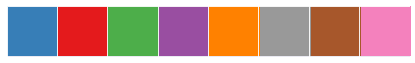

In [9]:
import matplotlib as mpl
from cycler import cycler

bmap = sns.color_palette("Set1", 9)
colors = np.array(bmap)[(1,0,2,3,4,8,6,7), :]
mpl.rcParams['axes.prop_cycle'] = cycler('color', colors)
colors_labels = ['blue', 'red', 'green', 'violet', 'orange', 'gray', 'brown', 'pink', ]
for c, cl in zip(colors, colors_labels):
    locals()[cl] = tuple(c) # assign variables with color names
sns.palplot(colors)

## Data files

Data folder:

In [10]:
data_dir = './data/multispot/'

Check that the folder exists:

In [11]:
data_dir = os.path.abspath(data_dir) + '/'
assert os.path.exists(data_dir), "Path '%s' does not exist." % data_dir

List of data files in `data_dir`:

In [12]:
from glob import glob
file_list = sorted(glob(data_dir + '*_?.hdf5'))

In [13]:
labels = ['12d', '7d', '17d', '22d', '27d', 'DO']
files_dict = {lab: fname for lab, fname in zip(sorted(labels), file_list)}
files_dict

{'12d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/multispot/12d_New_30p_320mW_steer_3.hdf5',
 '17d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/multispot/17d_100p_320mW_steer_1.hdf5',
 '22d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/multispot/22d_30p_320mW_steer_1.hdf5',
 '27d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/multispot/27d_50p_320mW_steer_1.hdf5',
 '7d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/multispot/7d_New_150p_320mW_steer_3.hdf5',
 'DO': '/Users/anto/Google Drive/notebooks/multispot_paper/data/multispot/DO12_No2_50p_320mW_steer_1.hdf5'}

## Correction parameters

### Multispot

Load the **multispot leakage coefficient** from disk (computed in [Multi-spot 5-Samples analyis - Leakage coefficient fit](Multi-spot 5-Samples analyis - Leakage coefficient fit.ipynb)):

In [14]:
_fname = 'results/Multi-spot - leakage coefficient KDE wmean DexDem.csv'
leakageM = np.loadtxt(_fname, ndmin=1)

print('Leakage coefficient:', leakageM)

Leakage coefficient: [ 0.0334]


Load the **multispot direct excitation coefficient** ($d_{dirT}$) from disk (computed in [usALEX - Corrections - Direct excitation physical parameter](usALEX - Corrections - Direct excitation physical parameter.ipynb)):

In [15]:
_fname = 'results/usALEX - direct excitation coefficient dir_ex_t beta.csv'
dir_ex_tM = np.loadtxt(_fname, ndmin=1)

print('Direct excitation coefficient (dir_ex_t):', dir_ex_tM)

Direct excitation coefficient (dir_ex_t): [ 0.04932]


Load the **multispot gamma** ($\gamma_M$) coefficient (computed in [Multi-spot Gamma Fitting](Multi-spot Gamma Fitting.ipynb)):

In [16]:
_fname = 'results/Multi-spot - gamma factor.csv'
gammaM = np.loadtxt(_fname, ndmin=1)

print('Multispot gamma coefficient:', gammaM)

Multispot gamma coefficient: [ 0.45525]


### usALEX

Load the **usALEX leakage coefficient** from disk (computed in [usALEX - Corrections - Leakage fit](usALEX - Corrections - Leakage fit.ipynb)):

In [17]:
_fname = 'results/usALEX - leakage coefficient DexDem.csv'
leakageA = np.loadtxt(_fname)

print('usALEX Leakage coefficient:', leakageA)

usALEX Leakage coefficient: 0.10029


Load the **usALEX gamma coefficient** (computed in [usALEX - Corrections - Gamma factor fit](usALEX - Corrections - Gamma factor fit.ipynb)):

In [18]:
_fname = 'results/usALEX - gamma factor - all-ph.csv'
gammaA = np.loadtxt(_fname)

print('usALEX Gamma-factor:', gammaA)

usALEX Gamma-factor: 1.020526


Load the **usALEX beta coefficient** (computed in [usALEX - Corrections - Gamma factor fit](usALEX - Corrections - Gamma factor fit.ipynb)):

In [19]:
_fname = 'results/usALEX - beta factor - all-ph.csv'
betaA = np.loadtxt(_fname)

print('usALEX Gamma-factor:', betaA)

usALEX Gamma-factor: 0.813553


Load the **usALEX direct-excitation coefficient** ($d_{exAA}$) (computed in [usALEX - Corrections - Direct excitation fit](usALEX - Corrections - Direct excitation fit.ipynb)):

In [20]:
_fname = 'results/usALEX - direct excitation coefficient dir_ex_aa.csv'
dir_ex_aa = np.loadtxt(_fname)

print('Direct excitation coefficient (dir_ex_aa):', dir_ex_aa)

Direct excitation coefficient (dir_ex_aa): 0.06062


Compute **usALEX direct-excitation coefficient** ($d_{exT}$) (see [usALEX - Corrections - Direct excitation physical parameter](usALEX - Corrections - Direct excitation physical parameter.ipynb)):

In [21]:
dir_ex_tA = betaA * dir_ex_aa
dir_ex_tA

0.04931758286

## Parameters

Analysis parameters:

In [22]:
donor_ref = False    # False -> gamma correction is: g*nd + na
                     # True  -> gamma correction is: nd + na/g

hist_weights = 'size'

## Background fit parameters
bg_kwargs_auto = dict(fun=bg.exp_fit,
                 time_s = 30,
                 tail_min_us = 'auto',
                 F_bg=1.7,
                 )

## Burst search
F=6
dither = False
size_th = 30    # Burst size threshold (selection on corrected burst sizes)

## FRET fit parameters
bandwidth = 0.03        # KDE bandwidth
E_range = {'7d':  (0.7, 1.0), '12d': (0.4, 0.8), '17d': (0.2, 0.4), 
           '22d': (0.0, 0.1), '27d': (0.0, 0.1), 'DO': (0.0, 0.1)}
E_axis_kde = np.arange(-0.2, 1.2, 0.0002)

## Utility functions

In [23]:
def print_fit_report(E_pr, gamma=1, leakage=0, dir_ex_t=0, math=True):
    """Print fit and standard deviation for both corrected and uncorrected E
    Returns d.E_fit.
    """
    E_corr = fretmath.correct_E_gamma_leak_dir(E_pr, gamma=gamma, leakage=leakage, dir_ex_t=dir_ex_t)
    
    E_pr_mean = E_pr.mean()*100
    E_pr_delta = (E_pr.max() - E_pr.min())*100
    
    E_corr_mean = E_corr.mean()*100
    E_corr_delta = (E_corr.max() - E_corr.min())*100
    if math:
        display(Math(r'\text{Pre}\;\gamma\quad\langle{E}_{fit}\rangle = %.1f\%% \qquad'
                     '\Delta E_{fit} = %.2f \%%' % \
                     (E_pr_mean, E_pr_delta)))
        display(Math(r'\text{Post}\;\gamma\quad\langle{E}_{fit}\rangle = %.1f\%% \qquad'
                     '\Delta E_{fit} = %.2f \%%' % \
                     (E_corr_mean, E_corr_delta)))
    else:
        print('Pre-gamma  E (delta, mean):  %.2f  %.2f' % (E_pr_mean, E_pr_delta))
        print('Post-gamma E (delta, mean):  %.2f  %.2f' % (E_corr_mean, E_corr_delta))

# Multispot analysis

In [24]:
d = loader.photon_hdf5(files_dict[data_id])
d.calc_bg(**bg_kwargs_auto)
d.burst_search(m=10, F=F, dither=dither)

 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [25]:
d.time_max

242.06434648749999

In [26]:
ds = Sel(d, select_bursts.size, th1=30, gamma=gammaM, donor_ref=donor_ref)

In [27]:
ds.num_bursts

array([343, 259, 369, 518, 367, 299, 458, 484])

In [28]:
# fitter = bext.bursts_fitter(ds)
# fitter.histogram(bins=np.r_[-0.2 : 1.2 : bandwidth])
# fitter.model = mfit.factory_two_gaussians(add_bridge=False, p2_center=0.4)
# fitter.fit_histogram()
# display(fitter.params['p2_center'])
# print_fit_report(fitter.params['p2_center'], gamma=gammaM, leakage=leakageM, dir_ex_t=dir_ex_tM)

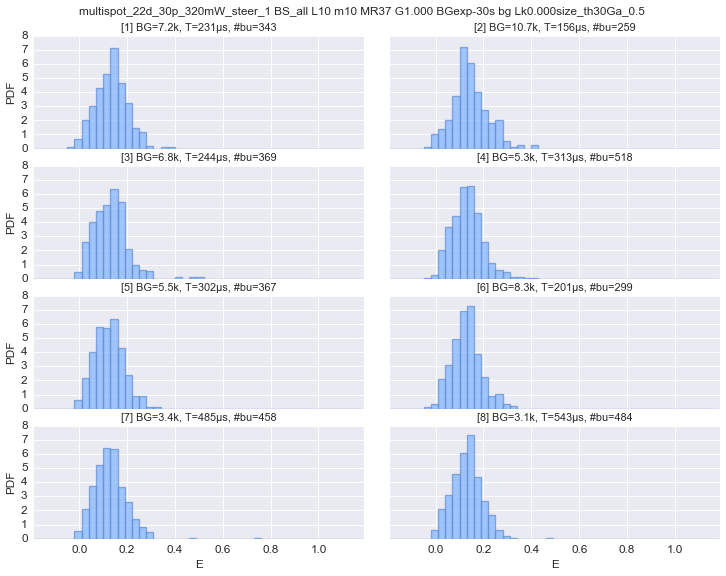

In [29]:
dplot(ds, hist_fret);
      #show_model=True, show_fit_stats=True, fit_from='p2_center', show_fit_value=True);

In [30]:
d_all = ds.collapse()

In [31]:
d_all_chunk = Sel(d_all, select_bursts.time, time_s2=600/8)

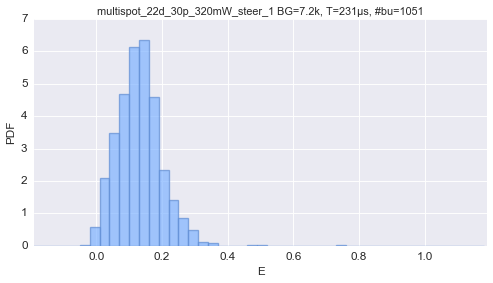

In [32]:
dplot(d_all_chunk, hist_fret)

In [33]:
Eraw = d_all_chunk.E[0]

In [34]:
E = fretmath.correct_E_gamma_leak_dir(Eraw, gamma=gammaM, leakage=leakageM, dir_ex_t=dir_ex_tM)

In [35]:
sns.set_style('whitegrid')
%config InlineBackend.figure_format='retina'  # for hi-dpi displays

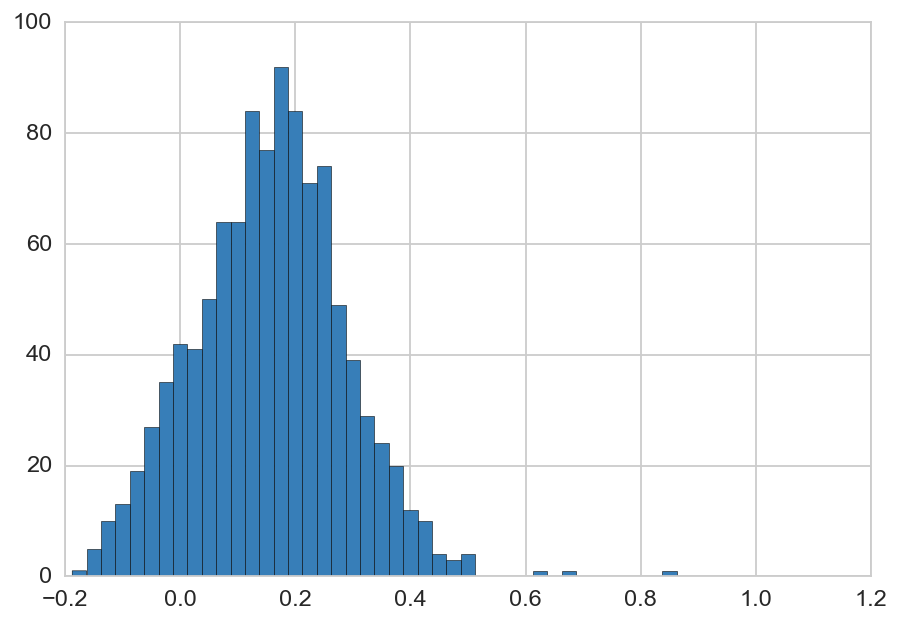

In [36]:
plt.hist(E, bins=np.arange(-0.2, 1.2, 0.025) + 0.5*0.025);

# Comparison with usALEX

In [37]:
bursts_usalex = pd.read_csv('results/bursts_usALEX_{sample}_{ph_sel}_F{F:.1f}_m{m}_size{th}.csv'
                            .format(sample=data_id, ph_sel='Dex', m=10, th=30, F=7), index_col=0)
bursts_usalex

,E,S,bg_a,bg_aa,bg_d,bp,i_end,i_start,na,naa,nd,nda,nt,size_raw,t_end,t_start,width_ms
0,0.101327,0.576924,1.146,1.108,0.819,0,244,176,3.854,27.892,34.181,-0.078,65.927,69,0.019155,0.017787,1.3675
1,0.291418,0.379612,2.434,2.353,1.740,0,668,576,9.566,53.647,23.260,-0.165,86.473,93,0.075242,0.072338,2.9041
2,0.306610,0.818797,1.382,1.336,0.988,0,994,949,10.618,7.664,24.012,-0.094,42.293,46,0.097801,0.096152,1.6493
3,0.141549,0.640530,2.551,2.466,1.824,0,1972,1884,7.449,29.534,45.176,-0.173,82.159,89,0.291788,0.288744,3.0438
4,0.294684,0.615903,1.983,1.917,1.417,0,2074,2020,9.017,19.083,21.583,-0.134,49.683,55,0.305755,0.303389,2.3658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2793,0.203951,0.859869,2.640,2.526,1.951,9,2095524,2095436,14.360,11.474,56.049,-0.156,81.884,89,597.349493,597.346186,3.3070
2794,0.276357,0.609822,1.464,1.401,1.082,9,2096836,2096729,17.536,40.599,45.918,-0.087,104.054,108,597.733336,597.731502,1.8338
2795,0.095553,0.931480,2.039,1.951,1.507,9,2097207,2097158,3.961,3.049,37.493,-0.121,44.504,50,597.847055,597.844501,2.5542
2796,0.094269,0.995352,1.877,1.796,1.387,9,2097256,2097207,4.123,0.204,39.613,0.889,43.940,50,597.849406,597.847055,2.3514


In [38]:
Eraw_alex = bursts_usalex.E

In [39]:
E_alex = fretmath.correct_E_gamma_leak_dir(Eraw_alex, gamma=gammaA, leakage=leakageA, dir_ex_t=dir_ex_tA)

Saved: figures/Multispot vs usALEX FRET hist comp sample 22d


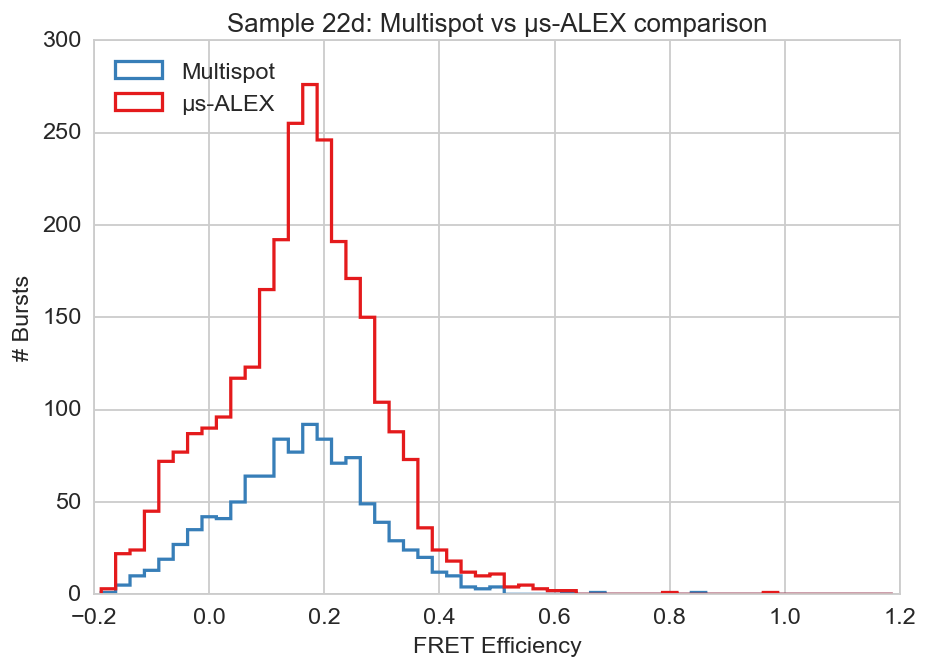

In [40]:
kws = dict(bins=np.arange(-0.2, 1.2, 0.025) + 0.5*0.025, histtype='step', lw=1.8)
plt.hist(E, label='Multispot', **kws)
plt.hist(E_alex, label='μs-ALEX', **kws)
plt.legend(loc=2)
plt.title('Sample %s: Multispot vs μs-ALEX comparison' % data_id)
plt.xlabel('FRET Efficiency')
plt.ylabel('# Bursts');
savefig('Multispot vs usALEX FRET hist comp sample %s' % data_id)

Saved: figures/Multispot vs usALEX FRET hist comp sample 22d normed


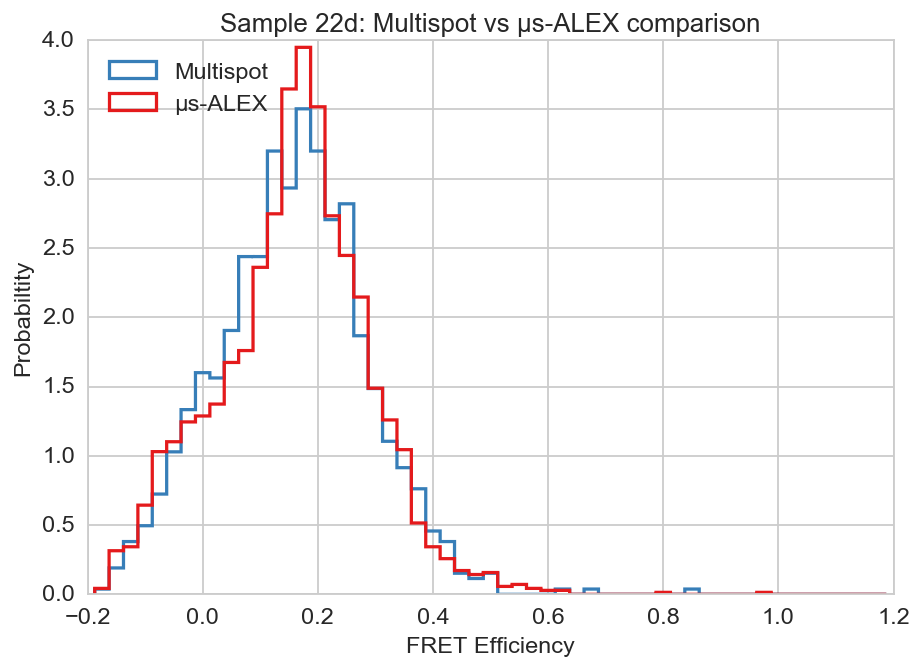

In [41]:
kws = dict(bins=np.arange(-0.2, 1.2, 0.025) + 0.5*0.025, histtype='step', lw=1.8, normed=True)
plt.hist(E, label='Multispot', **kws)
plt.hist(E_alex, label='μs-ALEX', **kws)
plt.legend(loc=2)
plt.title('Sample %s: Multispot vs μs-ALEX comparison' % data_id)
plt.xlabel('FRET Efficiency')
plt.ylabel('Probabiltity');
savefig('Multispot vs usALEX FRET hist comp sample %s normed' % data_id)